# Intro + Load Tide Data



Now we managed to create a circuit that represents our reservoir, however to facilitate we created a package to use our function. We will now show how we can `use Linear Optics to do Reservoir Computing!`

But first we need data we can test on, we were given EDF data, but it was too eratic so we decided to start using simpler data with more time correlation. We will use Tide data from 'https://www.digitalocean.ie/Data/DownloadTideData' for the Aranmore Island - Leabgarrow measurement station from April 2023 to Now (November 2023). We will use the water height as our input.

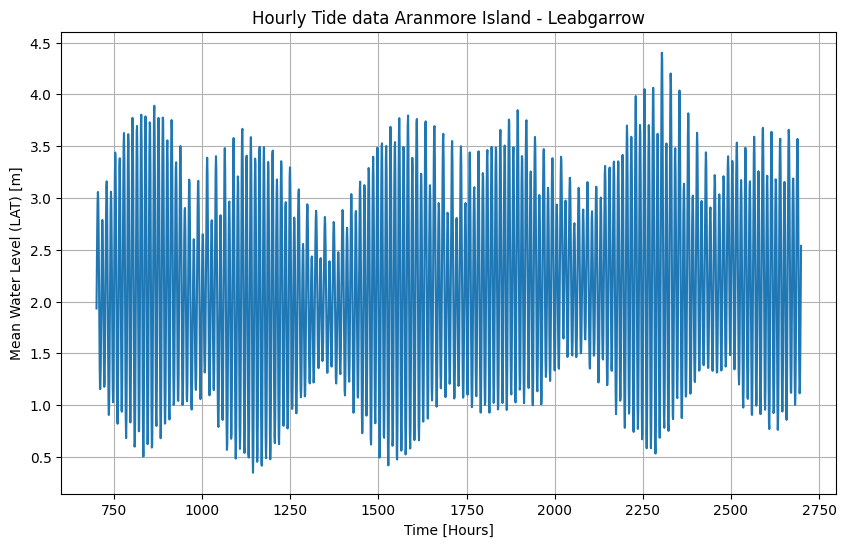

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import perceval as pcvl
import lo_reservoir as lrs # this is the reservoir module

# Load the data and drop the columns we don't need
file_name = "Data/IrishNationalTideGaugeNetwork_8335_68d5_7ab9.csv"
df = pd.read_csv(file_name)
df.drop(columns=['latitude', 'longitude', 'Water_Level_OD_Malin'], inplace=True)
df = df.iloc[1:]
df['Water_Level_LAT'] = df['Water_Level_LAT'].astype(float) # convert height to float

# mean the data so that we have hourly data
mean_every_12_rows = df.groupby(df.index // 12)['Water_Level_LAT'].mean()[700:2700]

plt.figure(figsize=(10, 6))
plt.plot(mean_every_12_rows.index, mean_every_12_rows.values)
plt.title('Hourly Tide data Aranmore Island - Leabgarrow')
plt.xlabel('Time [Hours]')
plt.ylabel('Mean Water Level (LAT) [m]')
plt.grid(True)
plt.show()

# Generate the Reservoir Computing outcome data

In [33]:
# Rescale the data such that it is in [0, 2*pi] because we will parametrize angles with it
data = np.array(mean_every_12_rows)
data = (data - data.min())/(data.max() - data.min()) * 2 * np.pi

# Create the parameter matrix by repeating the heigh data in a row (we parametise each PS and BS the same)
# (This seems naive but we have 1d data and our circuit is designed to work with high dimensional data)
m = 9 # number of modes (we cannot go to high because of computational speed)
train_matrix = np.tile(data, ((m-1)*5, 1)).transpose()

# Create the reservoir
t_max = train_matrix.shape[0] # max number of time steps
simulator = lrs.PhotonicReservoirSimulator(m, t_max, overlapping=True) # initialize the reservoir simulator

# generate the layers (computational speed trick: we pregenerate t_max parametrized layers and store them to later compute the ciruit)
_ = simulator.set_circuit_with_stored_layers()

Generating layers: 100%|██████████| 2000/2000 [00:06<00:00, 300.21it/s]


In [ ]:
# Now we can generate the reservoir states
input_state = input_state = pcvl.BasicState([1]*(m-1) + [0]*1) # this has empirically been found to be a good input state


memory_length = 100 # the number of time steps the reservoir remembers when seeing new data
full_expectation_matrix = simulator.sequential_expectation_with_memory(train_matrix, 
                                                                        input_state,
                                                                        memory_length=100)

# Take a 400 points long subset of the data
full_expectation_matrix = full_expectation_matrix[:400]
new_data = data[:400]

print("expectations_matrix.shape = ", np.array(full_expectation_matrix).shape)

Processing time steps: 100%|██████████| 500/500 [01:15<00:00,  6.66it/s]

expectations_matrix.shape =  (400, 9)


In [35]:
# If the computation is too long we can also load a previous calculated expectation matrix
import pickle

# Open the full_expectation_matrix
input_state = pcvl.BasicState([1]*(m-1) + [0]*1)
full_expectation_matrix = pickle.load(open(f"Data/full_expectation_matrix_2000.pkl", "rb"))

full_expectation_matrix = full_expectation_matrix[:400]
new_data = data[:400]

# FINALLY: Predicting data

### A) Predicting Chunks of Tide Data

Because the reservoir is predicting future data, the further we want to predict the worse the prediction gets. So we focused on predicting chunks of `10h tide data` in between. We decided on 10h because it is still a pretty long and usefull prediction time and the results manage to detect and predict the tide's main features.

In [36]:
# Lets separate our hash matrix in train and test chunks
chunk_length = 10  # Length of each test data chunk
interval = 50     # Interval between start of each test chunk
total_length = len(full_expectation_matrix)
start_index = 150 # Adjust the start of the range to skip the first 100 indices, so that it saw enough data to train

# Selecting chunks for test data
test_indices = [i for j in range(start_index, total_length, interval) for i in range(j, min(j + chunk_length, total_length))]
test_expectation_matrix = full_expectation_matrix[test_indices]
test_x = new_data[test_indices]

# Remaining data for training
train_expectation_matrix = np.delete(full_expectation_matrix, test_indices, axis=0)
train_x = np.delete(new_data, test_indices, axis=0)

print("train_expectation_matrix.shape = ", train_expectation_matrix.shape)
print("test_expectation_matrix.shape = ", test_expectation_matrix.shape)


train_expectation_matrix.shape =  (350, 9)
test_expectation_matrix.shape =  (50, 9)


In [37]:
# Let's now fit and predict the data!

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

expectations_matrix_red = np.array(train_expectation_matrix)[:-1] # Pop the last row of expectations_matrix
labels = np.array(train_x)[1:] # Make the prediction vector (predicting time step t+1)

poly = PolynomialFeatures(degree=12) # We are using a rich polynomial feature to capture the non-linearities
expectations_matrix_quad = poly.fit_transform(expectations_matrix_red)

# Fit the model
reg_ridge = Ridge(alpha=2).fit(expectations_matrix_quad, labels)

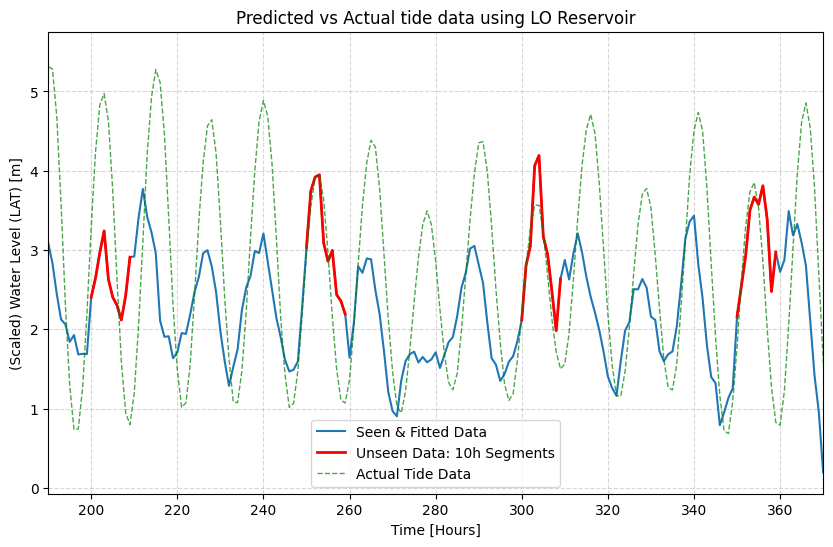

In [38]:
# Lets plot our results

# Transform to get the polynomial features
test_expectation_matrix_quad = poly.fit_transform(test_expectation_matrix)
train_expectation_matrix_quad = poly.fit_transform(train_expectation_matrix)

# Predict the data
predicted_train_data_quad = reg_ridge.predict(train_expectation_matrix_quad) - 0.7
predicted_test_data_quad = reg_ridge.predict(test_expectation_matrix_quad)

FULL_predictions = np.empty_like(new_data)
train_indices = [i for i in range(len(new_data)) if i not in test_indices]
FULL_predictions[train_indices] = predicted_train_data_quad
FULL_predictions[test_indices] = predicted_test_data_quad

FULL_predictions_series = pd.Series(FULL_predictions)
window_size = 4 
FULL_predictions_smoothed = FULL_predictions_series.rolling(window=window_size).mean()

# Shift the actual data to the left due to timeseries prediction
shift = 2
shifted_x = np.arange(shift, len(new_data) + shift)  # Shift the x-axis to the left due to timeseries prediction

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(FULL_predictions_smoothed, label='Seen & Fitted Data')

# Highlight the test predictions in red
for start in test_indices[::chunk_length]:
    end = start + chunk_length
    smoothed_segment = FULL_predictions_smoothed[start:end]
    plt.plot(range(start, min(end, len(FULL_predictions))), smoothed_segment, color='red', linewidth=2)

# Add a representative line for the test predictions in the legend
plt.plot([], [], color='red', linewidth=2, label=f'Unseen Data: {chunk_length}h Segments')

# Plot the actual data shifted to the left
plt.plot(shifted_x, new_data[:], label='Actual Tide Data', color='green', alpha=0.7, linestyle="--", linewidth=1)

# Set title and labels
plt.title(f'Predicted vs Actual Tide data using LO Reservoir')
plt.xlabel('Time [Hours]')
plt.ylabel('(Scaled) Water Level (LAT) [m]')

# Zoom in on a specific x-axis range
x_min = 190  # Replace with your desired minimum x-value
x_max = 370  # Replace with your desired maximum x-value
plt.xlim(x_min, x_max)

plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.show()


### B) Predicting Chunks of Tide Data

We also tried to predict future data for a longer size, this is what came out:

In [39]:
# Train Test split
split_int = 50 # 50

test_expectation_matrix = full_expectation_matrix[-split_int:]
train_expectation_matrix = full_expectation_matrix[:-split_int]
print("train_expectation_matrix.shape = ", np.array(train_expectation_matrix).shape)
print("test_expectation_matrix.shape = ", np.array(test_expectation_matrix).shape)

test_x = new_data[-split_int:]
train_x = new_data[:-split_int]

train_expectation_matrix.shape =  (350, 9)
test_expectation_matrix.shape =  (50, 9)


In [40]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Assuming 'train_expectation_matrix' and 'train_x' are defined and available

# Pop the last row of expectations_matrix
expectations_matrix_red = np.array(train_expectation_matrix)[:-1]
print("expectations_matrix.shape = ", expectations_matrix_red.shape)

# Make prediction vector
labels = np.array(train_x)[1:]
data_red = np.array(train_x)[:]
print("labels:", labels[:3])
print("data_red: ", data_red[:4])
print("labels shape: ", labels.shape)

# Transform the data to include quadratic terms
poly = PolynomialFeatures(degree=12)
expectations_matrix_quad = poly.fit_transform(expectations_matrix_red)

# Fit the quadratic model with Ridge regularization
# You can adjust the alpha parameter to control the strength of the regularization
reg_ridge = Ridge(alpha=2).fit(expectations_matrix_quad, labels)

expectations_matrix.shape =  (349, 9)
labels: [3.0797902  3.62419429 4.04912655]
data_red:  [2.4571159  3.0797902  3.62419429 4.04912655]
labels shape:  (349,)


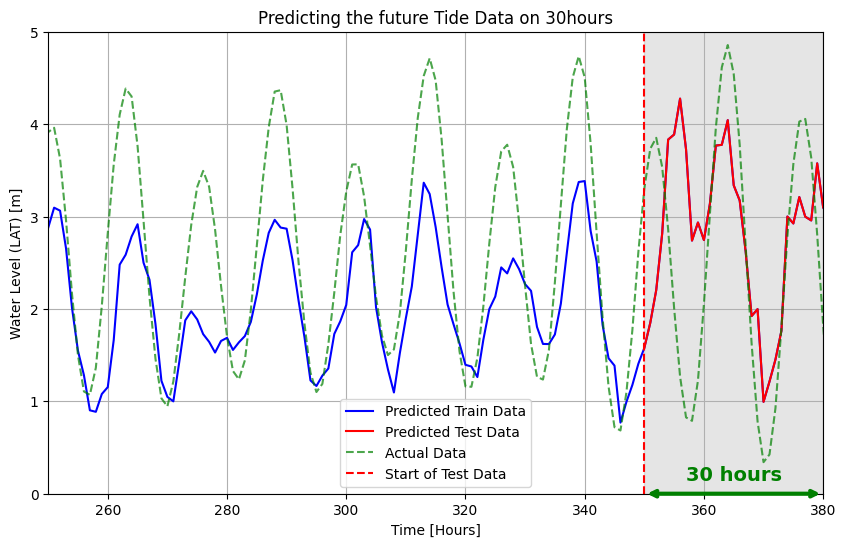

In [42]:
# Transform the training data to include quadratic terms
test_expectation_matrix_quad = poly.fit_transform(test_expectation_matrix)
# Make predictions using the quadratic model
predicted_test_data_quad = reg_ridge.predict(test_expectation_matrix_quad)


train_expectation_matrix_quad = poly.fit_transform(train_expectation_matrix)
# Make predictions using the quadratic model
predicted_train_data_quad = reg_ridge.predict(train_expectation_matrix_quad) - 0.7

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'predicted_train_data_quad', 'predicted_test_data_quad', and 'new_data' are defined

# Append predicted train quad and test quad
FULL_data_quad = np.append(predicted_train_data_quad, predicted_test_data_quad)

# Convert the FULL_data_quad array to a pandas Series for easy manipulation
FULL_data_quad_series = pd.Series(FULL_data_quad)

# Apply a moving average (rolling mean)
window_size = 4  # Adjust the window size as needed
FULL_data_quad_smoothed = FULL_data_quad_series.rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the smoothed train predictions in blue and connect to test predictions
plt.plot(FULL_data_quad_smoothed, color='blue', label='Predicted Train Data')

# Plot the smoothed test predictions in red from test_start_index
test_start_index = len(predicted_train_data_quad)
plt.plot(range(test_start_index, len(FULL_data_quad_smoothed)), FULL_data_quad_smoothed[test_start_index:], color='red', label='Predicted Test Data')


# Plot the actual data in green dashed line
plt.plot(new_data[:], color='green', alpha=0.7, linestyle='--', label='Actual Data')

# Add a vertical line at test_start_index
plt.axvline(x=test_start_index, color='red', linestyle='--', label='Start of Test Data')


# Shade the test data region
x_max = 380  # Replace with your desired maximum x-value
plt.fill_betweenx(y=[-10, 10], x1=test_start_index, x2=x_max, color='grey', alpha=0.2)

# Set title and labels
plt.title(f'Predicting the future Tide Data on 30hours')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')

# Set the x-axis limits to zoom in
x_min = 250  # Replace with your desired minimum x-value
plt.xlim(x_min, x_max)

y_min = 0
y_max = 5
plt.ylim(y_min, y_max)

# Add a horizontal double arrow
hours_length = x_max - test_start_index
plt.annotate(
    '', 
    xy=(test_start_index, 0), xycoords='data',
    xytext=(test_start_index + hours_length, 0), textcoords='data',
    arrowprops=dict(arrowstyle='<->', color='green', linewidth=3)
)

# Increase the y-coordinate for text to add space between the text and the arrow
text_y_position = 0.1
plt.text(test_start_index + hours_length / 2, text_y_position, f'{hours_length} hours', 
         verticalalignment='bottom', horizontalalignment='center', 
         color='green', fontsize=14, fontweight='bold')

plt.legend()
plt.grid(True)
plt.show()


# Discussion

We can see that our reservoir, although not perfect, manages to capture the cyclic behavior of the tide data, and even predict it on unseen data for up to `30 hours in the future!`
